# Random Forest  Model Building and Evaluation

This notebook is used for training and evaluation of the two `Random Forest` models used for this project. To import the trained models and explore their prediction capabilities, skip to the section on error analysis, which imports the trained model. Before doing that however, ensure that the setup section is run to import the necessary modules.

# Setup

In [1]:
from modules.utils import SentimentDataset, SklearnModels, tf_idf, w2v, MODEL_PATH
from sklearn.ensemble import RandomForestClassifier
from datasets import load_dataset
import random
from tabulate import tabulate

# Modelling

## Word2Vec Embedding

In [20]:
# Loading data and apply embedding
data = SentimentDataset()
w2v(data)


Loading data...


Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)



Loading processed dataset from cache...
Dataset loaded


In [20]:
# Perfroming gridsearch on random forest
params = {
    'n_estimators': [50, 100, 250],
    'max_depth': [10, 50],
    'min_samples_leaf': [100, 500],
}


# Performing gridsearch with 5-folds cross validation
rfc = SklearnModels(model=RandomForestClassifier(random_state=42),
                          data_model=data,
                    model_name='RandomForest_w2v',
                          grid_search = True,
                          model_params = params,
                          scale=False,
                          verbose=3)

rfc.fit()

Performing grid search with 5-fold cross validation

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=10, min_samples_leaf=100, n_estimators=50;, score=(train=0.750, test=0.701) total time= 2.7min
[CV 3/5] END max_depth=10, min_samples_leaf=100, n_estimators=50;, score=(train=0.748, test=0.703) total time= 2.7min
[CV 2/5] END max_depth=10, min_samples_leaf=100, n_estimators=50;, score=(train=0.750, test=0.703) total time= 2.7min
[CV 4/5] END max_depth=10, min_samples_leaf=100, n_estimators=50;, score=(train=0.747, test=0.705) total time= 2.7min
[CV 5/5] END max_depth=10, min_samples_leaf=100, n_estimators=50;, score=(train=0.746, test=0.700) total time= 2.7min
[CV 1/5] END max_depth=10, min_samples_leaf=500, n_estimators=50;, score=(train=0.712, test=0.695) total time= 2.2min
[CV 1/5] END max_depth=10, min_samples_leaf=100, n_estimators=100;, score=(train=0.752, test=0.703) total time= 5.3min
[CV 4/5] END max_depth=10, min_samples_leaf=100, n_estimato

In [25]:
# Saving model 
rfc.save()

## TF-IDF Embedding

In [42]:
# Initiating new dataset
tfidfData = SentimentDataset()

Loading data...


Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)



Loading processed dataset from cache...
Dataset loaded


In [43]:
# Applying tf-idf to data
tf_idf(tfidfData)

TF-IDF embedding applied


In [50]:
# Training the model using the best params from first grid search
param_tf = {'max_depth': [50], 'min_samples_leaf': [100], 'n_estimators': [250]}

rfc_tf = SklearnModels(model=RandomForestClassifier(random_state=42),
                             data_model=tfidfData,
                             model_name = 'RandomForest_tf-idf',
                             grid_search = True,
                             model_params = param_tf,
                             scale=False,
                             verbose=3,
                             cv=2)

rfc_tf.fit()

Performing grid search with 2-fold cross validation

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END max_depth=50, min_samples_leaf=100, n_estimators=250;, score=(train=0.728, test=0.721) total time=  27.2s
[CV 1/2] END max_depth=50, min_samples_leaf=100, n_estimators=250;, score=(train=0.736, test=0.728) total time=  27.5s
Best params: {'max_depth': 50, 'min_samples_leaf': 100, 'n_estimators': 250}


## TF-IDF 

## Evaluate

### Word2Vec

In [27]:
# Classification report for word2vec model
print(f'{rfc.model_name}')
rfc.evaluate_on_test(accuracy=False, classification_rep=True)

RandomForest_w2v
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71     19934
           1       0.72      0.70      0.71     20066

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.71     40000
weighted avg       0.71      0.71      0.71     40000



<Figure size 720x576 with 0 Axes>

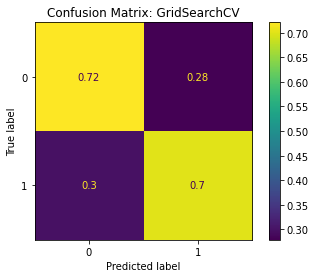

In [28]:
# Confusion matrix for word2vec model
rfc.evaluate_on_test(confusion_mat=True, print_out=False)
rfc.plot_confusion_matrix()

### TF-IDF

In [51]:
# Accuracy of for tf-idf model
print(f'{rfc_tf.model_name}')
rfc_tf.evaluate_on_test(accuracy=True)

RandomForest_tf-idf
Test Accuracy:  0.7385


In [52]:
# Classification report of tf-idf model
print(f'{rfc_tf.model_name} - Text Representation Method: {tfidfData.embedding_type}')
rfc_tf.evaluate_on_test(accuracy=False, classification_rep=True)

RandomForest_tf-idf - Word Embedding Type TF-IDF
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73     20015
           1       0.72      0.77      0.75     19985

    accuracy                           0.74     40000
   macro avg       0.74      0.74      0.74     40000
weighted avg       0.74      0.74      0.74     40000



<Figure size 720x576 with 0 Axes>

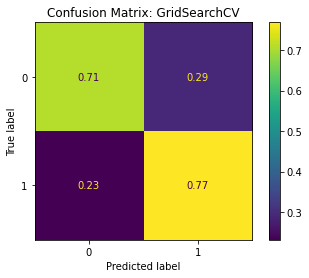

In [53]:
# Confusion matrix for tf-idf version of random forest model
rfc_tf.evaluate_on_test(confusion_mat=True, print_out=False)
rfc_tf.plot_confusion_matrix()

In [55]:
# Saving model
rfc_tf.save()

## Errors

### W2V

In [31]:
# Loading new dataset
df = load_dataset('sentiment140')

# Create subset based on new data
test_set = df['train'].to_pandas().groupby('sentiment').apply(
    lambda x: x[-1000:]).reset_index(drop=True).replace(4, 1).sample(frac=1)

# Process it similarly to the training data
sentences = SentimentDataset(
    test_set.text.to_list(), subset='test').process_data()

# Apply word2vec on it
vectorized = w2v(sentences, return_vector=True).vector

# Target list
target = test_set.sentiment.to_list()


Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Processing
Processing test input
Applying Word2Vec embedding
Loading Word2Vec model from directory
Vectorizing range(0, 2000) tweets
Word2Vec embedding applied


In [38]:
# Load model from model directory
rf_word2vec = SklearnModels(model_name='RandomForest_w2v',
                            split=False).load_model()


Loading model


In [39]:
# Perform predictions
rf_w2v_prediction = rf_word2vec.model.predict(vectorized)

In [42]:
# Indices of wrong predictions
wrong_predictions = [i for i, (a, b) in enumerate(
    zip(rf_w2v_prediction, target)) if a != b]

# Random list of 5 index positions
indexes = [wrong_predictions[random.randint(
    0, len(wrong_predictions)-1)] for _ in range(5)]

# Original tweet
original = test_set.text.to_list()

# Processed tweet
processed = sentences

In [45]:
# Create a table for tabulate
table = [[original[i], processed[i], target[i], rf_w2v_prediction[i]]
         for i in indexes]


In [48]:
print(tabulate(table, headers=["Original Tweet","Processed Tweet", "True Label", "Predicted Label"]))

Original Tweet                                                                          Processed Tweet                                     True Label    Predicted Label
--------------------------------------------------------------------------------------  ------------------------------------------------  ------------  -----------------
@rainnwilson a NSFW warning would have been nice                                        nsfw warning would nice                                      0                  1
@whenyougethigh Well said. Keep us updated!                                             well said keep u updated                                     0                  1
Rest In Peace Farrah!                                                                   rest peace farrah                                            0                  1
@cryssie awww. Farrah Fawcett known as a Charlie Angel in 1970's. Now, she is no more.  awww farrah fawcett known charlie angel 1970                 0

### TF-IDF

In [57]:
# Similarly_ load data on new data
sentences_2 = SentimentDataset(
    test_set.text.to_list(), subset='test').process_data()

Processing
Processing test input


In [56]:
# Initialize training data, to apply tf-idf. We will need to do it on the training data to ensure the tf-idf model is fitted to this
tf_idf_data = SentimentDataset()
tf_idf(tf_idf_data)


Loading data...


Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)



Loading processed dataset from cache...
Dataset loaded
TF-IDF embedding applied


In [58]:
# Apply tf-idf to new data
tf_idf_vector = tf_idf_data.tfidf_vectorize(sentences_2)

In [61]:
# Load model from model directory
rf_tfidf = SklearnModels(model_name='RandomForest_tf-idf',
                         split=False).load_model()

# Perform predictions
tfidf_predictions = rf_tfidf.model.predict(tf_idf_vector)

Loading model


In [63]:
# Indices of wrong predictions
wrong_predictions_2 = [i for i, (a, b) in enumerate(
    zip(tfidf_predictions, target)) if a != b]

# Random list of 5 index positions
indexes_2 = [wrong_predictions_2[random.randint(
    0, len(wrong_predictions_2)-1)] for _ in range(5)]

# Original tweet
original = test_set.text.to_list()

# Processed tweet
processed = sentences

In [69]:
# Create table with wrong predictions
table = [[original[i], processed[i], target[i], tfidf_predictions[i]]
         for i in indexes_2]

print('Random Forrest TF-IDF Word Embedding - Wrong Predictions\n')
print(tabulate(table, headers=["Original Tweet","Processed Tweet", "True Label", "Predicted Label"]))


Random Forrest TF-IDF Word Embedding - Wrong Predictions

Original Tweet                                                                                                      Processed Tweet                                    True Label    Predicted Label
------------------------------------------------------------------------------------------------------------------  -----------------------------------------------  ------------  -----------------
looking a little pink                                                                                               looking little pink                                         0                  1
@pauldawalibi @nairapemberton What's wrong with Plain Jane?                                                         wrong plain jane                                            0                  1
We will always love Farrah Fawcett, R.I.P.                                                                          always love farrah fawcett r p        